In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera
from IPython.display import HTML

import importlib
import warnings
import numpy as np
import pandas as pd
import copy
import random
from tslib.src import tsUtils
from tslib.tests import testdata
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
from filter_data import *
from load_and_clean import *
import hdbscan
%matplotlib inline

In [30]:
import warnings
warnings.filterwarnings('ignore')

## Pre-processing data

In [31]:
#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [32]:
#Load and clean all raw data

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, country_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True)
state_reopen = load_clean('state reopen')

These countries/region do not have population data ['Virgin Islands']
These countries/region do not have population data ['Bahamas', 'Burma', 'Cabo Verde', 'Congo (Brazzaville)', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Diamond Princess', 'Eswatini', 'Gambia', 'Holy See', 'Kyrgyzstan', 'MS Zaandam', 'North Macedonia', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Syria', 'Taiwan*', 'West Bank and Gaza', 'Western Sahara']
These countries/region do not have population data ['Adjuntas-Puerto Rico', 'Aguada-Puerto Rico', 'Aguadilla-Puerto Rico', 'Aguas Buenas-Puerto Rico', 'Aibonito-Puerto Rico', 'Anasco-Puerto Rico', 'Anchorage-Alaska', 'Arecibo-Puerto Rico', 'Arroyo-Puerto Rico', 'Barceloneta-Puerto Rico', 'Barranquitas-Puerto Rico', 'Bayamon-Puerto Rico', 'Cabo Rojo-Puerto Rico', 'Caguas-Puerto Rico', 'Camuy-Puerto Rico', 'Canovanas-Puerto Rico', 'Carolina-Puerto Rico', 'Catano-Puerto Rico', 'Cayey-Puerto Rico', 'Ceiba-Puerto Rico', 'Ciales-Puerto

In [33]:
#Filter data 
# This part might be to split and explain
# This part might be to split and explain
t = 7

global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)

last date
Exceptions are []


## Find the target areas by threshold values of deaths

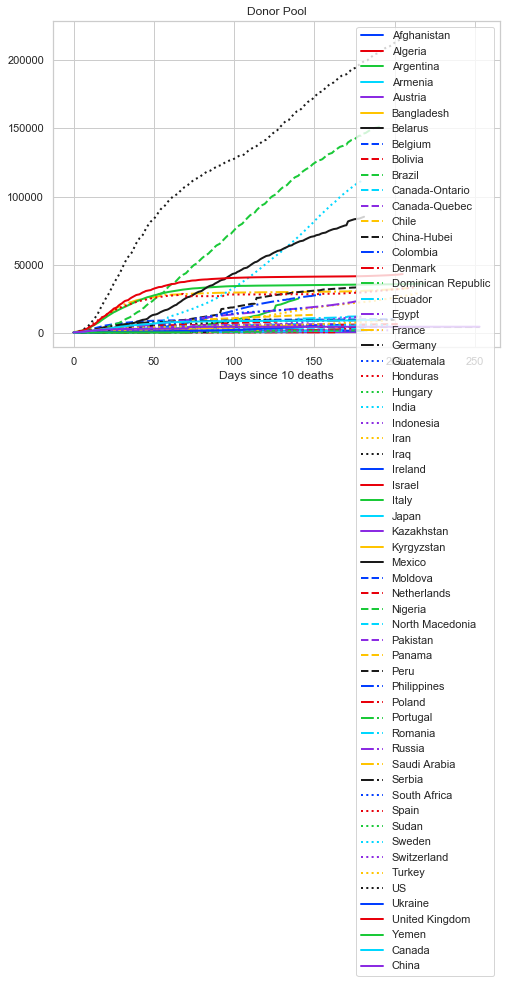

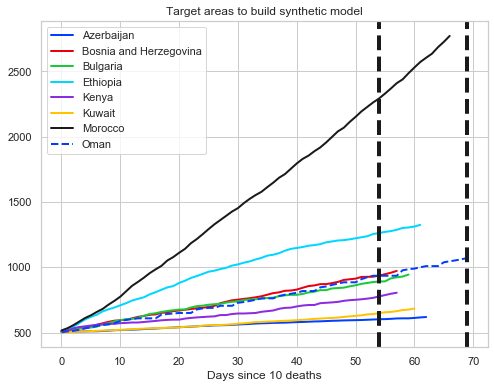

In [34]:
#plt.rcParams['figure.figsize'] = (12.0, 9.0)
#plt.rcParams.update({'font.size': 8})


sizes = global_deaths_filtered.apply(pd.Series.last_valid_index)  
low_thresh=55
threshold=70
donorlpool = list(sizes[sizes>threshold].index)

global_deaths_filtered[donorlpool].plot( grid=True, title='Donor Pool', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.show()

prediction_states = list(sizes[(sizes>low_thresh) & (sizes<threshold)].index)
global_deaths_filtered[prediction_states].plot(grid=True, title='Target areas to build synthetic model', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)
plt.axvline(x=threshold-1, color='k', linestyle='--', linewidth=4)
plt.show()

## Apply synthetic control to New York - what if shutdown was carried out early

### Without population adjusted

In [45]:

targets = ['New York']# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 3
lambdas = [1]


for target in targets:
    fig, axes = plt.subplots(figsize=(16,6))
    camera = Camera(fig)
    
    for i in range(1,15):
        temp_df, date = filter_data_by_intervention(all_data_daily[[target]], educational_distancing, i)

        return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], 60,22, "7-day moving average of daily cases", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target+" -%s"%i], showstates=12, svdSpectrum = False,
                                   exclude=[target, 'China-Hubei'], animation=camera, figure=fig, axes=[axes], showDonors=False, silent=True, showPlots=True, error_thresh=8000, FONTSIZE=14)
        #error_thresh=3

    animation = camera.animate()

animation.save('New York new.mp4')
plt.close('all')
HTML(animation.to_html5_video())





## Permutation distribution graph

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


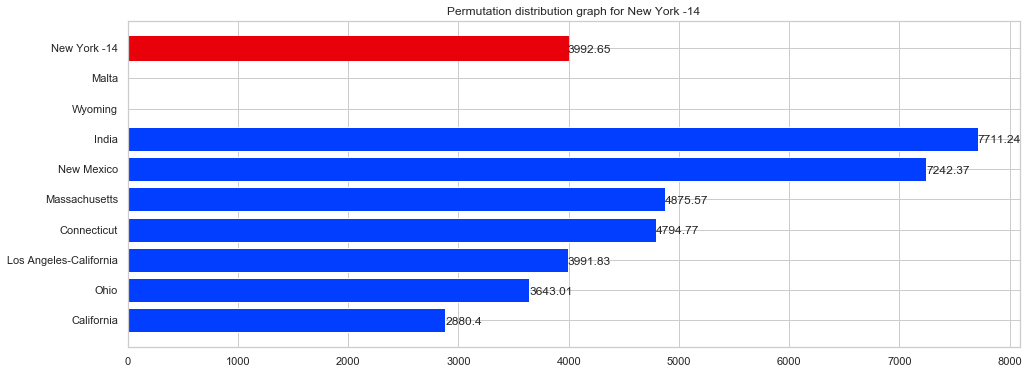

In [36]:
ri_dict = return_value[0].permutation_distribution(show_graph = True)

### With population adjusted

In [37]:

targets = ['New York']# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 3
lambdas = [1]


for target in targets:
    fig, axes = plt.subplots(figsize=(16,6))
    camera = Camera(fig)
    
    for i in range(1,15):
        temp_df, date = filter_data_by_intervention(all_cases_data_pop_daily[[target]], educational_distancing, i)

        return_value = synth_control_predictions([pd.concat([all_death_data_pop_adjusted_daily,temp_df], axis=1)], 60,22, "7-day moving average of daily cases with population adjusted", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target+" -%s"%i], showstates=12, 
                                   exclude=[target, 'China'], animation = camera, figure=fig, axes=[axes], showDonors=False, silent=True, showPlots=True, error_thresh=534261, yaxis = 'Cases per million people', FONTSIZE=14)
        #error_thresh = 3

    animation = camera.animate()

animation.save('New York new.mp4')
plt.close('all')
HTML(animation.to_html5_video())

## Apply synthetic control to reopen states - what if the states have not been reopened?

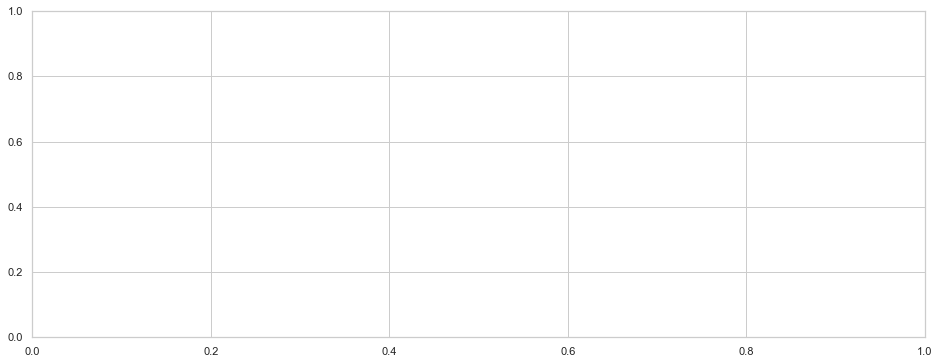

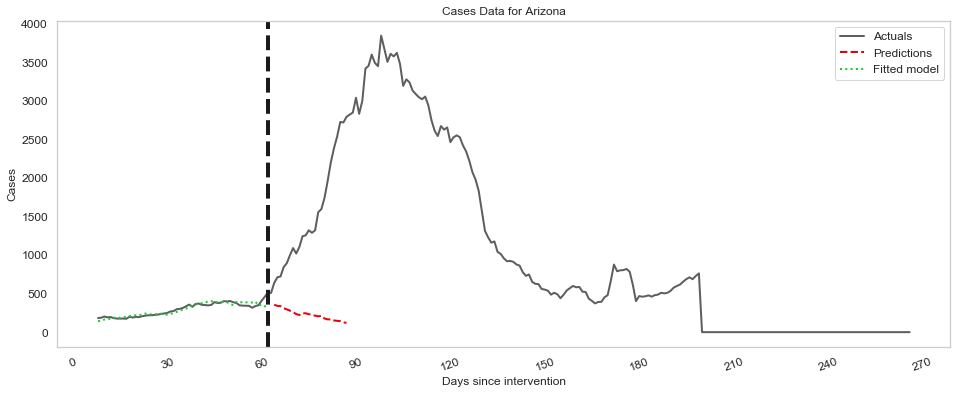

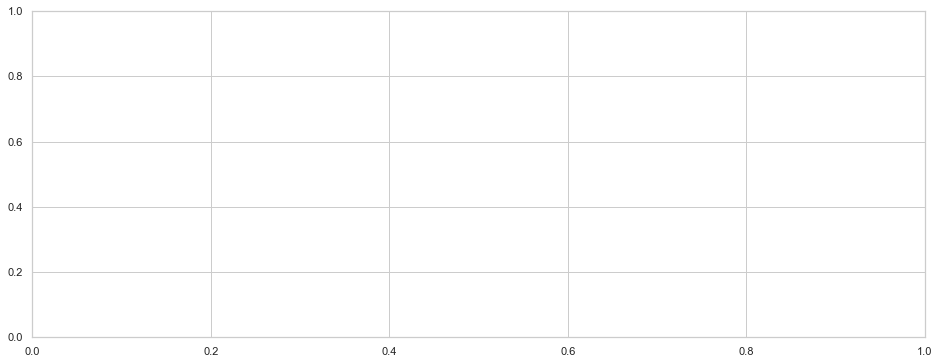

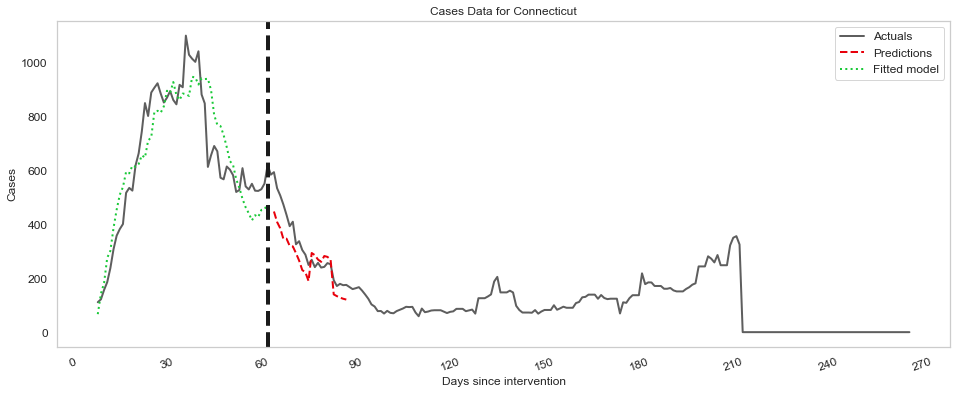

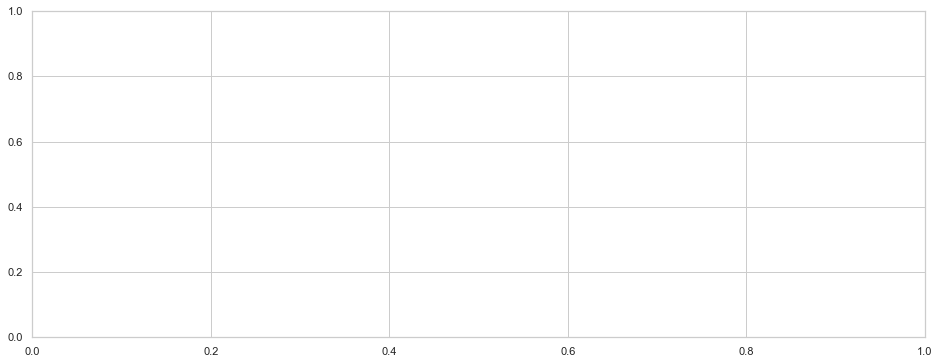

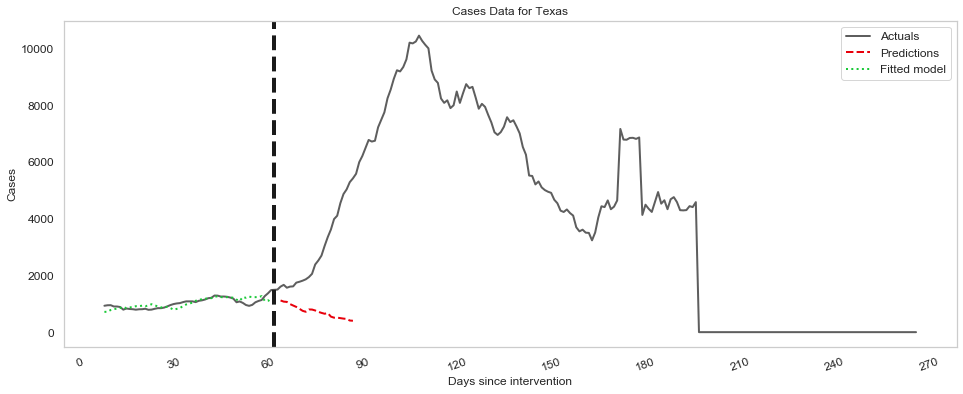

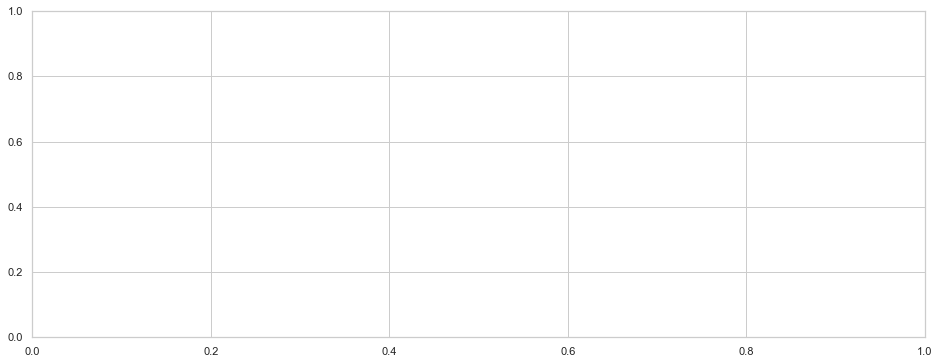

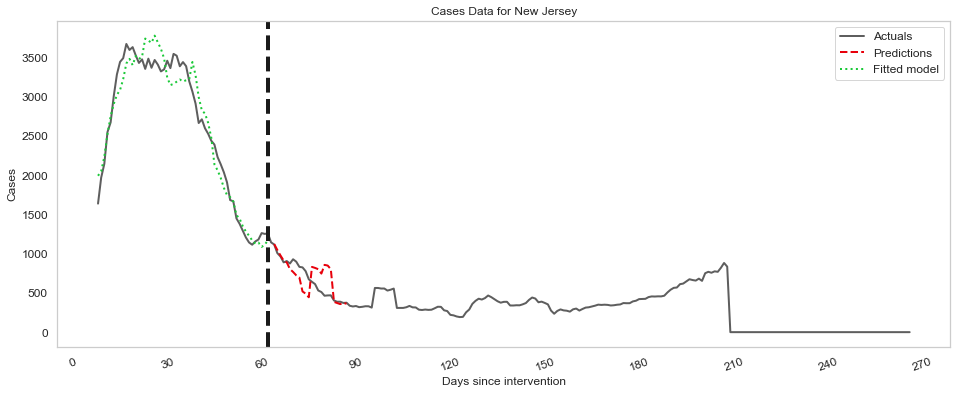

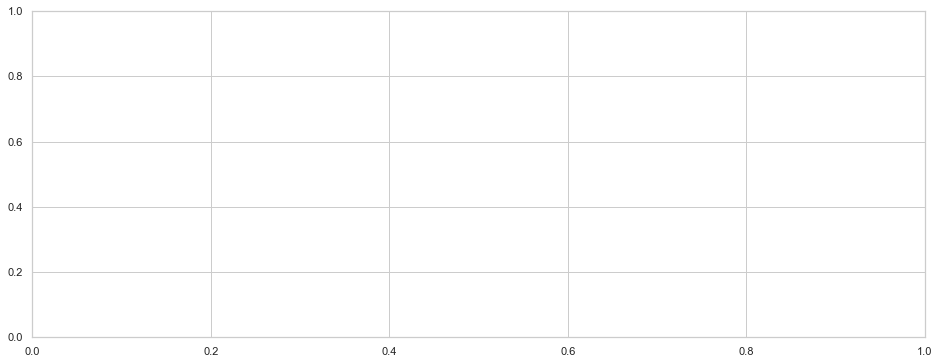

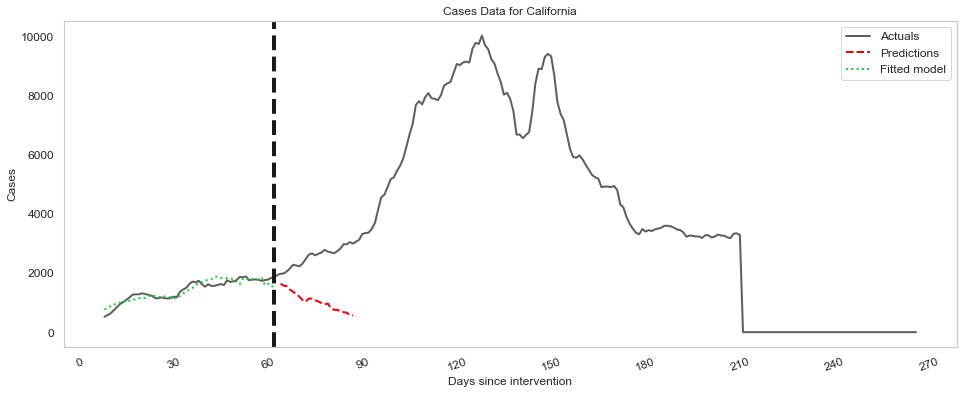

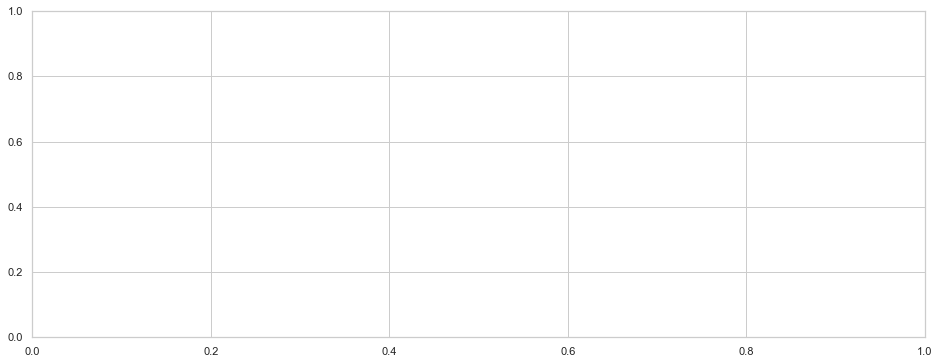

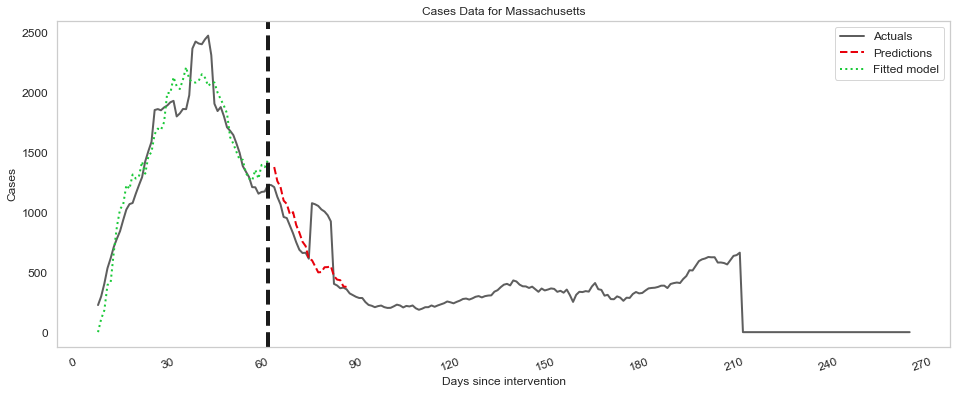

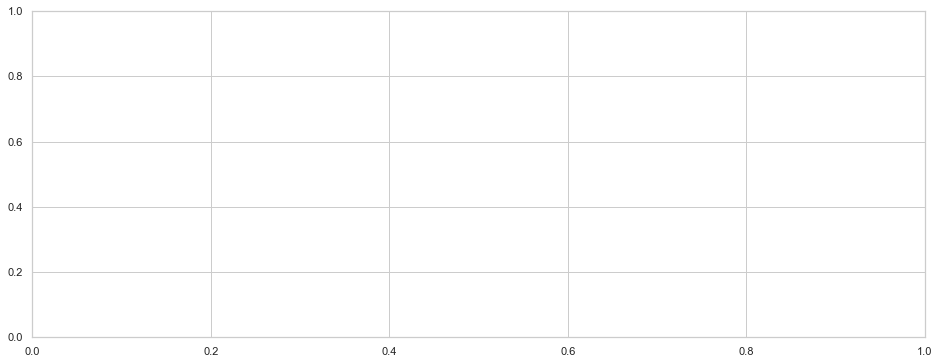

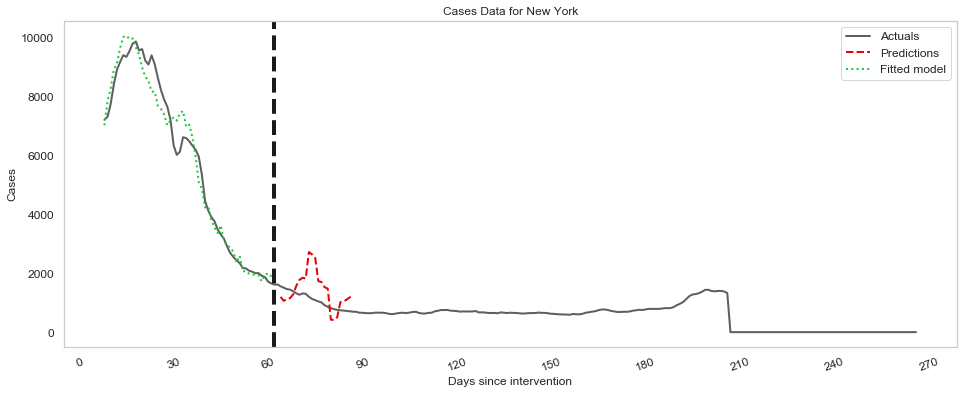

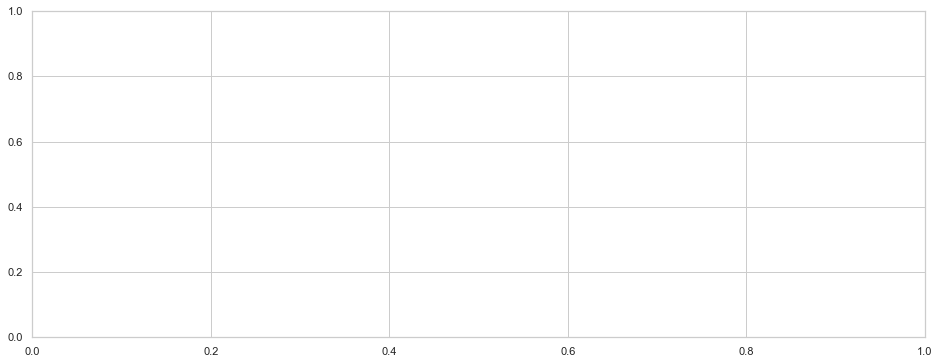

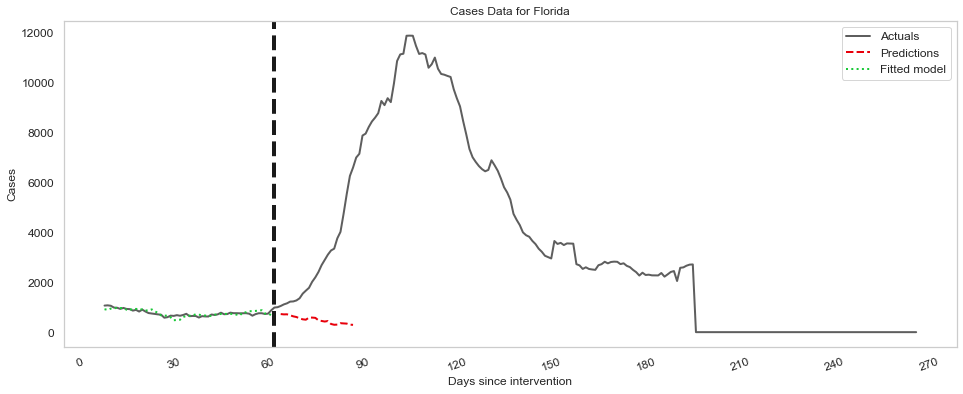

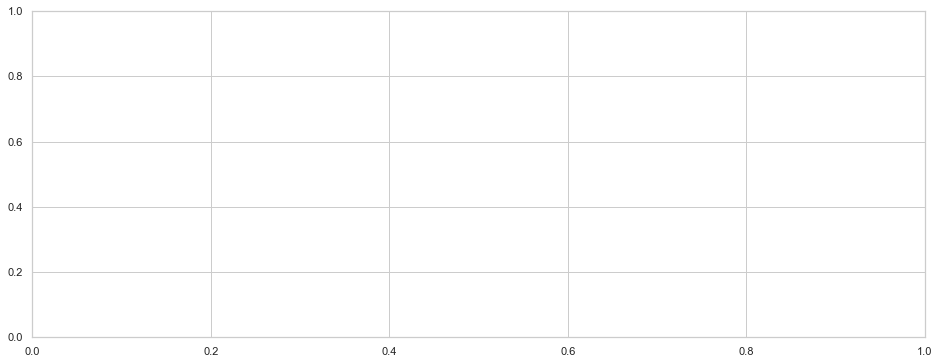

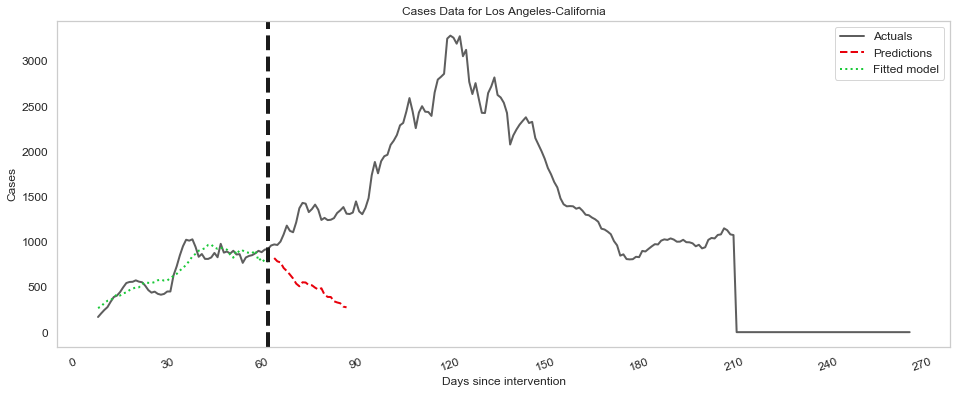

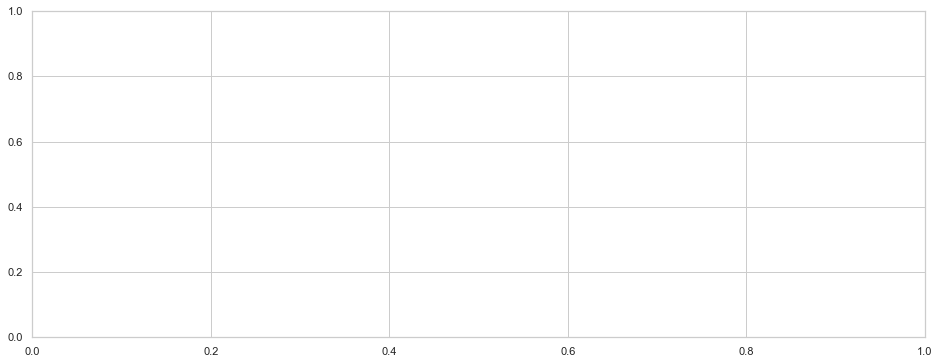

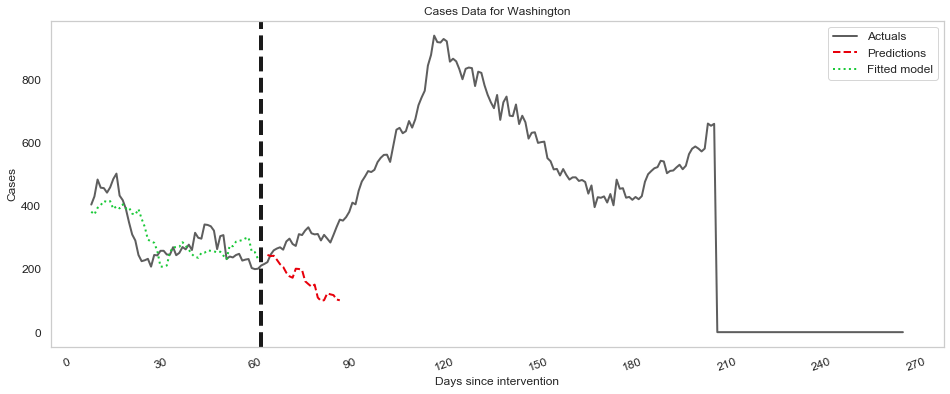

In [38]:
#plt.rcParams['figure.figsize'] = (12.0, 8.0)

df = deaths_intervention_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()

df1 = cases_intervention_adjusted_daily[df.columns].copy()

high_thresh = 80
low_thresh = 55

sizes = df[targets].apply(pd.Series.last_valid_index)
donorpool = sizes[sizes>=high_thresh].index

targets = ['Arizona','Connecticut', 'Texas', 'New Jersey','California', 'Massachusetts',  'New York', 'Florida', 'Los Angeles-California', 'Washington']
donors = ['New York', 'Rhode Island', 'New Jersey', 'Pennsylvania', 'Delaware', 'Connecticut','Michigan', 'Indiana', 'Illinois', 'Massachusetts']

#donors = ['Arizona', 'Florida', 'Texas', 'California', 'Alabama', 'Mississippi', 'New Jersey', 'Pennsylvania', 'Delaware', 'Connecticut']

singVals = 3
weight_features = []
move_intervention = 10
i=1
for target in targets:
  
    try:
        fig, axes = plt.subplots(figsize=(16,6))
        newdata = synth_control_predictions([df1],high_thresh, low_thresh,
                                            "Cases Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=donors, svdSpectrum=False, silent=True, showDonors=False, showPlots=True, mRSC=False, error_thresh = 265097, FONTSIZE=14)
        #error_thresh=10
        weight_features.append(newdata)
        i=i+1
    except ValueError:
        print(target)
        continue

## Predicting the evolution of cases and deaths in New York based on a western european donor pool

New York 178462.95298552737


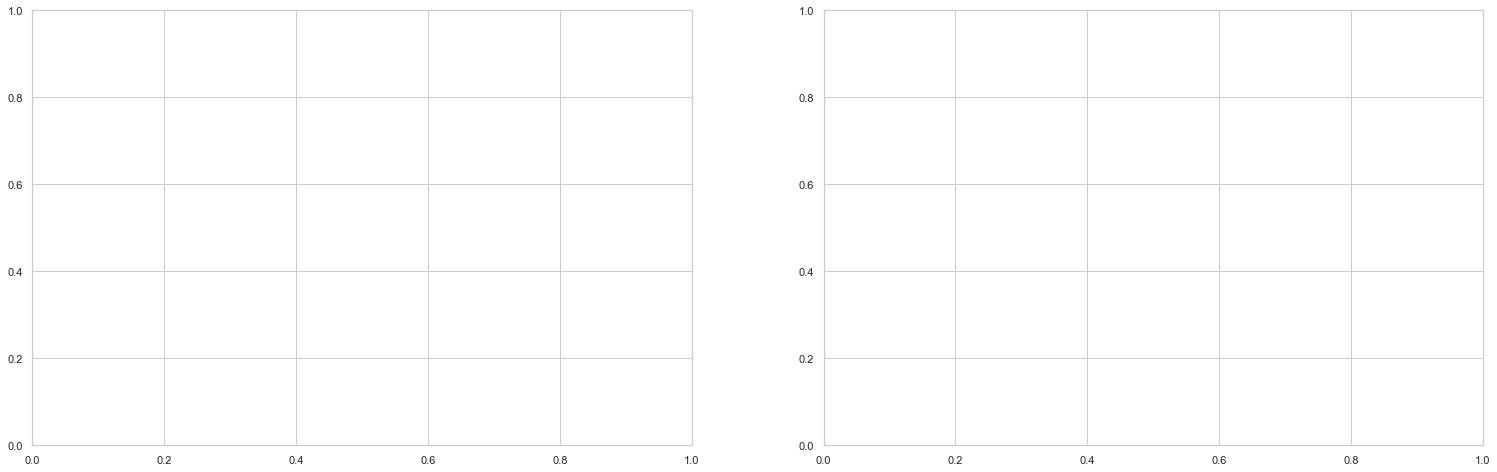

In [39]:
#plt.rcParams['figure.figsize'] = (24.0, 9.0)
#plt.rcParams.update({'font.size': 12})
lambdas = [1, 50]

projection_period=120
training_period=10
fig, axes = plt.subplots(1, 2, figsize=(26,8))
newdata = synth_control_predictions([df1, df],projection_period, training_period, 
                                            "Cases Data", 1, ylimit=[], savePlots=True, do_only=['New York'], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh = 10, FONTSIZE=30)



In [40]:
a = np.[1,2]
a.any()

SyntaxError: invalid syntax (<ipython-input-40-94e58bf502ae>, line 1)

In [ ]:
#plt.rcParams['figure.figsize'] = (24.0, 9.0)

lambdas = [1, 0.02]
projection_period=120
training_period=10
fig, axes = plt.subplots(1, 2, figsize=(26,8))
newdata = synth_control_predictions([df, df1],projection_period, training_period,
                                            "Deaths Data", 1, ylimit=[], savePlots=True, do_only=['New York'], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'],
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh = 10, FONTSIZE=30)





In [ ]:
singVals = 1
projection_period=130
training_period=20

fig, axes = plt.subplots(1, 2, figsize=(26,8))
temp_df,_= filter_data_by_intervention(all_data_daily[['New York']], educational_distancing, 10)

# This has been made silent as to not flood the output
#[pd.concat([deaths_intervention_adjusted_daily,temp_df]
return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], projection_period, training_period, "Deaths data", singVals, ylimit=[], 
                           savePlots=True, do_only=["New York -10"], showstates=10,
                           exclude=['New York'], figure=fig, axes=axes, donorPool=['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland'], 
                           svdSpectrum=False, silent=True, showDonors=True, showPlots=True,  mRSC=False, error_thresh = 10, FONTSIZE=30, yaxis = 'Deaths')#lambdas=lambdas, random_distribution=dist



## Comparing the evolution of COVID-19 in New York vs the rest of the country

In [ ]:
fig, ax = plt.subplots(1,1)

#plt.rcParams['figure.figsize'] = (16.0, 9.0)

tri_state = all_data_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']
tri_state_cases = all_data_cases_daily['New York']#+all_data_daily['New Jersey']+all_data_daily['Connecticut']

plt.rcParams.update({'font.size': 14})
us_minus_new_york = all_data_daily['US'] - tri_state
us_minus_new_york_cases = all_data_cases_daily['US'] - tri_state_cases

all_data_daily['US'].loc['2020-03-07':].plot(ax=ax, label='US Deaths'), tri_state.loc['2020-03-07':].plot(ax=ax, label="New York Deaths"), 
us_minus_new_york.loc['2020-03-07':].plot(ax=ax,color='k', label="US minus New York Deaths"), plt.ylabel('Moving Average Daily Deaths'), plt.legend(loc='upper right')

all_data_cases_daily['US'].loc['2020-03-07':].plot(ax=ax, label='US Cases', secondary_y=True,linestyle=":"), 
tri_state_cases.loc['2020-03-07':].plot(ax=ax, label="New York Cases", secondary_y=True,linestyle=":"),  
us_minus_new_york_cases.loc['2020-03-07':].plot(ax=ax, label="US minus New York Cases", secondary_y=True,linestyle=":"), plt.legend(loc='upper left'), plt.ylabel('Moving Average Daily Cases')
plt.show()
#deaths_intervention_adjusted_daily['Maryland'].plot(), deaths_intervention_adjusted_daily['Connecticut'].plot(), plt.legend(), plt.grid()

In [ ]:
us_minus_new_york_cases.plot(label="US minus New York Cases"),plt.legend(),all_data_cases_daily['Sweden'].plot(secondary_y=True), plt.legend()

## Some interesting parallels

In [ ]:

ax = plt.subplot(2,2,1)

deaths_intervention_adjusted_daily[['Connecticut', 'Sweden']].plot(ax=ax), plt.grid(),
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,2)

deaths_intervention_adjusted_daily[['Michigan', 'Netherlands']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,3)

deaths_intervention_adjusted_daily[['Delaware', 'Iowa']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

ax = plt.subplot(2,2,4)

deaths_intervention_adjusted_daily[['Ohio', 'Los Angeles-California']].plot(ax=ax), plt.grid(), 
plt.xticks(rotation=45), plt.xlabel('Days Since Lockdown'), plt.ylabel('Moving Average Daily Deaths')

plt.show()

## The Sweden herd immunity experiment

In [ ]:
#plt.rcParams['figure.figsize'] = (24.0, 8.0)

ax = plt.subplot(1,3,2)
targets = ['Sweden', 'Denmark', 'Finland', 'Norway']
deaths_intervention_adjusted[targets].plot(ax = ax), plt.xlabel('Days since lockdown'), plt.ylabel('Total Deaths')
ax = plt.subplot(1,3,3)

deaths_intervention_adjusted_daily[targets].plot(ax = ax), plt.xlabel('Days since lockdown'), plt.ylabel('Moving Average Daily Deaths')
#plt.show()
ax = plt.subplot(1,3,1)
plt.barh(all_population[all_population.index.isin(targets)].index, all_population[all_population.index.isin(targets)]['value'], 
         color=list('bgrcyk')),plt.xlabel('Population')

In [ ]:
df = deaths_intervention_adjusted
df1 = cases_intervention_adjusted
targets = ['Sweden']# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 3
lambdas = [1, 0.02]
donors = ['Denmark', 'Finland', 'Norway', 'Austria', 'Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland']

for target in targets:
    fig, axes = plt.subplots(figsize=(16,6))
    camera = Camera(fig)
    
    for i in range(5,30):
        return_value = synth_control_predictions([df, df1], 85,i, "7-day moving average of daily deaths", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target], showstates=12, donorPool=donors, lambdas=lambdas,
                                   animation = camera, figure=fig, axes=axes, showDonors=False, silent=True, showPlots=True, error_thresh=3)
    animation = camera.animate()

animation.save('Sweden.mp4')
plt.close('all')
HTML(animation.to_html5_video())

## All states cases and deaths at a glance

In [ ]:
plt.rcParams['figure.figsize'] = (24.0, 48.0)

plot_us = deaths_intervention_adjusted_daily.columns[deaths_intervention_adjusted_daily.columns.isin(uscases.columns)]
newfig=[16,32,48]

for i in range(1,52):

    ax = plt.subplot(13,4, i)
    deaths_intervention_adjusted_daily[plot_us[i-1]].iloc[25:].plot(ax = ax, color='r', label='deaths'), plt.legend(loc='best')
    
    cases_intervention_adjusted_daily[plot_us[i-1]].iloc[25:].plot(ax = ax, secondary_y=True, color='k', label='cases'), plt.legend(loc='best')
    plt.title(plot_us[i-1])
    if i in newfig:
    
        plt.show()


## Clustering without population adjustment

In [ ]:
df = deaths_intervention_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()
df1 = cases_intervention_adjusted_daily[df.columns].iloc[15:,:].copy()

lambdas=[1,0.01]
delta = 5
low_thresh = 50

targets = df.columns
sizes = df[targets].apply(pd.Series.last_valid_index)
targets = sizes[sizes>=low_thresh].index
#donorpool = sizes[sizes>=low_thresh + delta].index
donorpool = ['Northeast', 'Midwest', 'South', 'West']

singVals = 3
move_intervention = 10

features = cluster_trend([df, df1],10, low_thresh, targets, singVals, donorPool = donorpool,
                            exclude=[], lambdas=lambdas, mRSC=False, error_thresh = 1, 
                            cluster_method = 'HDBSCAN')
features

In [ ]:
xlabels = ['Days since lockdown', 'Chronological Date']
ylabels = ['Moving average of daily deaths', 'Moving average of daily deaths']
plot_cluster(features, [df, all_data_daily.loc['2020-03-02':,:]], xlabels, ylabels)

## Clustering with population adjustment

In [ ]:
df = all_death_data_pop_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()
df1 = all_cases_data_pop_adjusted_daily[df.columns].iloc[15:,:].copy()

lambdas=[1,0.01]
delta = 20
low_thresh = 30

targets = df.columns
sizes = df[targets].apply(pd.Series.last_valid_index)
targets = sizes[sizes>=low_thresh].index
donorpool = list(sizes[sizes>=low_thresh + delta].index)

#donorpool = ['Northeast', 'Midwest', 'South', 'West']

singVals = 3

features = cluster_trend([df, df1],delta, low_thresh, targets, singVals, donorPool = donorpool,
                            exclude=[], lambdas=lambdas, mRSC=False, error_thresh = 1, 
                            cluster_method = 'HDBSCAN')
features

In [ ]:
xlabels = ['Days since lockdown', 'Chronological Date']
ylabels = ['Moving average of daily deaths per million', 'Moving average of daily deaths per million']
plot_cluster(features, [df, all_cases_data_pop_daily.loc['2020-03-02':,:]], xlabels, ylabels)

## Clustering US counties

In [ ]:
uscounties_cases.index = pd.to_datetime(uscounties_cases.index)
new_df = pd.DataFrame()
low_thresh = {}
donorpool = ['northeast', 'midwest', 'south', 'west']
for county in uscounties_cases:
    state = county.split('-')[1]
    if (sd_data['name'] == state).any():
        intervention_date = pd.to_datetime(sd_data[sd_data['name'] == state]['last date'].values[0])
        
        start_date = uscounties_cases[county][uscounties_cases[county] > 0 ].index
        if len(start_date) > 0:
            start_date = start_date[0]
        else:
            continue
        
        reopen_date = state_reopen[state_reopen['State'] == state]['Expires'].values[0]
        #print(reopen_date)
        if reopen_date != 'No Stay Home Order':
            if pd.isna(reopen_date):
                delta = 70
            else:
                reopen_date = datetime.datetime.strptime(reopen_date,'%m/%d/%Y')
                delta = (reopen_date - intervention_date).days

            low_thresh[county] = delta
            new_df = pd.concat([new_df, pd.Series(uscounties_cases[county][uscounties_cases[county].index > intervention_date].values, name = county)], axis = 1 )
new_df = new_df.fillna(0)
counties_cases_daily = create_rolling_data(new_df)

In [ ]:
df = counties_cases_daily
df = df[df.columns[(df>10).any()]].copy()
df1 = counties_cases_daily[df.columns].iloc[15:,:].copy()

lambdas=[1,0.01]
delta = 20

targets = df.columns
sizes = df[targets].apply(pd.Series.last_valid_index)
targets = sizes[sizes>= 60].index

donorpool = list(sizes[sizes>=80].index)
#donorpool = ['northeast', 'midwest', 'south', 'west']
singVals = 3

features = cluster_trend([df], delta, low_thresh, targets, singVals, donorPool = donorpool,
                            exclude=[], lambdas=lambdas, mRSC=False, error_thresh = 5, 
                            cluster_method = 'HDBSCAN', cluster_size = 5)
features

In [ ]:
select_feature = {i:features[i] for i in range(10)}

In [ ]:
xlabels = ['Days since lockdown']
ylabels = ['Moving average of daily deaths per million']
plot_cluster(features, [df], xlabels, ylabels)